##### Teoretiska frågor 
1. Beskriv kort hur en relationsdatabas fungerar.
I en databas samlas information på ett sätt som gör det lätt att söka efter, hämta och ändra i hela eller delar av informationen. I en relationsdatabas är informationen strukturerad i tabeller (relationer). Varje tabell består av rader, individuella dataposter, och kolumner, attribut eller egenskaper för data. Varje tabell har en primärnyckel som unikt definerar varje rad. En tabell länkas till andra tabeller (relationer tabeller emellan) med hjälp av en främmande nyckel. 
En relationsdatabas använder SQL för att utföra operationer som att skapa, läsa, uppdatera och ta bort data.

2. Vad menas med “CRUD”-flödet?
De fyra grundläggande operationerna som används för att hantera data i en databas. 
Create: Skapa tabeller och lägga till nya rader i en tabell. 
Read: Hämta data från tabeller. 
Update: Uppdatera/Ändra data i tabeller.
Delete: Radera data i tabeller.  

3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?
JOIN i SQL används för att kombinera kolumner från en eller flera tabeller till en ny tabell. 

INNER JOIN: Returnerar endast de rader som det finns en match till i båda tabellerna. Används när man endast vill ha data som är gemensam två tabeller emellan. 
LEFT JOIN: Returnerar alla rader från den 'vänstra' tabellen, även om det inte finns någon match i den 'högra' tabellen. För de rader utan match fylls värdena med NULL. Används när man vill se all data från en tabell och lägga till eventuell data som finns från en annan tabell. 

4. Beskriv kort vad indexering i SQL innebär.
Vid indexering organiseras datan i en tabell på ett sätt som gör det snabbare att hitta och läsa specifika rader i en tabell. Ett index är som en bokstavsregister eller innehållsförteckning i en bok. Utan indexering måste systemet gå igenom tabellen rad för rad vid sökning. 

Fördel: Det går snabbare att söka igenom data. 
Nackdel: Det går långsammare att lägga till, uppdatera och ta bort data.

5. Beskriv kort vad en vy i SQL är.
En vy är en virtuell tabell som baseras på resultatet från en SQL-query. Datan i en vy lagras inte i databasen, utan själva frågan lagras. Tabellen skapas dynamiskt när querien körs. Detta gör att data alltid är uppdaterad. 

Vyer är ett bra verktyg för att förenkla, säkra och organisera queries. Hjälper användaren att slippa skriva komplexa frågor om och om igen, användaren behöver inte känna till den underliggande strukturen av databasen och åtkomst till känsliga kolumner kan begränsas. 

6. Beskriv kort vad en lagrad procedur i SQL är.
En lagrad procedur är en lagrad programkod som kan köras vid behov. Precis som en vy lagras inte data, utan själva frågan lagras. Till skillnad från en vy, som endast visar data, kan man även uppdatera och ta bort data med hjälp av en lagrad procedur. De lagrade procedured stödjer även mer komplexa operationer såsom loopar och villkor. 

##### Sammanfattning
En så kallad executive summary, det vill säga runt 10 meningar som sammanfattar
det viktigaste du kommit fram till. Detta brukar till exempel chefer vara intresserade
av.

##### Importera bibliotek och sätt upp database connection

In [1]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
from graphviz import Digraph
import pyodbc
import numpy as np
import geopandas as gpd
import plotly.express as px
from shapely import wkt
from scipy.stats import t
from scipy.stats import ttest_ind
from tabulate import tabulate

# Anslut till SQL Server-databasen med Windows Authentication
DATABASE_URI = "mssql+pyodbc://TERESE/AdventureWorks2022?driver=ODBC+Driver+17+for+SQL+Server"

# Skapa en engine för att ansluta till databasen
engine = create_engine(DATABASE_URI)
connection = engine.connect()

##### Bakgrund AdventureWorks-databasen
Databasen representerar ett företag som producerar och säljer cyklar och cykeldelar. 
Databasen innehåller information om anställda, försäljning, kunder och produktion. 
Eftersom databasen innehåller kopplingar mellan olika områden är det möjligt att analysera samband mellan försäljning, lager och anställda. 

In [165]:
# Hämta och skriv ut användarscheman i databasen för överblick av vad databasen innehåller. Exkluderar systemscheman.

query = """
SELECT name AS 'Användarscheman'
FROM sys.schemas 
WHERE name NOT IN ('sys', 'guest', 'INFORMATION_SCHEMA', 'db_owner', 'db_accessadmin', 
                   'db_securityadmin', 'db_ddladmin', 'db_backupoperator', 
                   'db_datareader', 'db_datawriter', 'db_denydatareader', 
                   'db_denydatawriter')
"""
df = pd.read_sql_query(query, engine)
print(df)


  Användarscheman
0             dbo
1  HumanResources
2          Person
3      Production
4      Purchasing
5           Sales


In [ ]:
# Organsiationsschema inklusive antalet anställda per avdelning och roll

query = """
SELECT 
    ED.Department,
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager' -- Missing data for CEO. Update in AdventureWorks in real life. 
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Team Lead'
        ELSE 'Employee'
    END AS RoleLevel,
    CASE 
        WHEN E.JobTitle LIKE 'Production Supervisor%' THEN 'Production Supervisor'
        WHEN E.JobTitle LIKE 'Production Technician%' THEN 'Production Technician'
        ELSE E.JobTitle
    END AS JobTitle,
    COUNT(*) AS Count
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
GROUP BY 
    ED.Department, 
    E.OrganizationLevel, 
    CASE 
        WHEN E.JobTitle LIKE 'Production Supervisor%' THEN 'Production Supervisor'
        WHEN E.JobTitle LIKE 'Production Technician%' THEN 'Production Technician'
        ELSE E.JobTitle
    END
"""
df = pd.read_sql(query, engine)

def build_hierarchy_text(df):
    text_representation = ""
    departments = df["Department"].unique()

    for dept in departments:
        text_representation += f"{dept}\n" 

        dept_data = df[df["Department"] == dept]

        levels = ["Top Manager", "Middle Manager", "Team Lead", "Employee"]
        for level in levels:
            level_data = dept_data[dept_data["RoleLevel"] == level]

            for _, row in level_data.iterrows():
                indent = "│   " * (levels.index(level))
                text_representation += f"{indent}├── {row['JobTitle']} ({row['Count']})\n"

    return text_representation

text_hierarchy = build_hierarchy_text(df)
print(text_hierarchy)

Document Control
│   │   ├── Document Control Manager (1)
│   │   │   ├── Control Specialist (2)
│   │   │   ├── Document Control Assistant (2)
Engineering
├── Vice President of Engineering (1)
│   ├── Engineering Manager (1)
│   │   ├── Design Engineer (3)
│   │   ├── Senior Design Engineer (1)
Executive
├── Chief Executive Officer (1)
├── Chief Financial Officer (1)
Facilities and Maintenance
│   ├── Facilities Manager (1)
│   │   ├── Facilities Administrative Assistant (1)
│   │   ├── Maintenance Supervisor (1)
│   │   │   ├── Janitor (4)
Finance
│   ├── Accounts Manager (1)
│   ├── Assistant to the Chief Financial Officer (1)
│   ├── Finance Manager (1)
│   │   ├── Accountant (2)
│   │   ├── Accounts Payable Specialist (2)
│   │   ├── Accounts Receivable Specialist (3)
Human Resources
│   ├── Human Resources Manager (1)
│   │   ├── Benefits Specialist (1)
│   │   ├── Human Resources Administrative Assistant (2)
│   │   ├── Recruiter (2)
Information Services
├── Information Services

In [167]:
# Karta över försäljningsplatser, produktion och huvudkontor. 
# Jag har plottat företagets butiker världen över. Företaget har försäljning i Nordamerika, Europa och Australien. 
# Det verkar som att en punkt utanför Afrika har felaktig data i databasen. 
# Då jag inte lyckats ta fram koordinater för produktionsanläggningar för företaget har jag istället valt att i kartan plotta
# vart anställda inom avdelningen Produktion är placerade. Alla dessa är placerade i nordvästra USA. 
# Jag har även plottat vart anställda inom avdelningen Executive är placerade. Dessa två sitter även de i nordvästra USA.
# Med ovan information drar jag slutsatsen att huvudkontor/ledning och produktion är placerade i USA, medan försäljning sker på flera kontinenter i världen. 

query_stores = '''
SELECT 
    'Store' AS Type,
    S.Name AS Name,
    A.City AS City,
    A.SpatialLocation.STAsText() AS Location
FROM Sales.vStoreWithAddresses S
INNER JOIN Person.BusinessEntityAddress BEA
    ON S.BusinessEntityID = BEA.BusinessEntityID
INNER JOIN Person.Address A
    ON BEA.AddressID = A.AddressID;
'''

query_employees = '''
SELECT 
    CASE 
        WHEN D.Name = 'Production' THEN 'Production Employee'
        WHEN D.Name = 'Executive' THEN 'Executive Employee'
    END AS Type,
    E.BusinessEntityID AS EmployeeID,
    P.FirstName + ' ' + P.LastName AS Name,
    A.City AS City,
    A.SpatialLocation.STAsText() AS Location
FROM HumanResources.Employee E
INNER JOIN Person.Person P
    ON E.BusinessEntityID = P.BusinessEntityID
INNER JOIN HumanResources.EmployeeDepartmentHistory EDH
    ON E.BusinessEntityID = EDH.BusinessEntityID
INNER JOIN HumanResources.Department D
    ON EDH.DepartmentID = D.DepartmentID
INNER JOIN Person.BusinessEntityAddress BEA
    ON E.BusinessEntityID = BEA.BusinessEntityID
INNER JOIN Person.Address A
    ON BEA.AddressID = A.AddressID
WHERE 
    A.SpatialLocation IS NOT NULL 
    AND EDH.EndDate IS NULL
    AND D.Name IN ('Production', 'Executive');
'''

stores_df = pd.read_sql(query_stores, engine)
employees_df = pd.read_sql(query_employees, engine)

stores_df['Location'] = stores_df['Location'].apply(lambda x: wkt.loads(x) if x else None)
employees_df['Location'] = employees_df['Location'].apply(lambda x: wkt.loads(x) if x else None)
stores_gdf = gpd.GeoDataFrame(stores_df, geometry='Location')
employees_gdf = gpd.GeoDataFrame(employees_df, geometry='Location')
stores_gdf = stores_gdf.set_crs(epsg=4326)
employees_gdf = employees_gdf.set_crs(epsg=4326)
combined_gdf = pd.concat([stores_gdf, employees_gdf], ignore_index=True)

fig = px.scatter_mapbox(
    combined_gdf,
    lat=combined_gdf.geometry.y,
    lon=combined_gdf.geometry.x,
    zoom=2,
    color='Type',
    opacity=0.75,
    title='Store and Employee Locations (Production and Executive)',
    hover_name='Name',
    hover_data={'City': True, 'Type': True}
)

fig.update_layout(mapbox_style='carto-positron', height=750)
fig.show()

In [272]:
# Företagets produkter uppdelat per kategori för att ge en överblick över produktkatalogen. 

query = """
SELECT 
    PC.Name AS ProductCategory,
    PSC.Name AS ProductSubcategory
FROM 
    Production.ProductCategory AS PC
LEFT JOIN 
    Production.ProductSubcategory AS PSC
    ON PC.ProductCategoryID = PSC.ProductCategoryID
ORDER BY 
    PC.Name ASC,
    PSC.Name ASC;
"""

# Hämta data från databasen
df = pd.read_sql(query, engine)

# Visa resultatet i en tabell
print(df)

   ProductCategory ProductSubcategory
0      Accessories         Bike Racks
1      Accessories        Bike Stands
2      Accessories  Bottles and Cages
3      Accessories           Cleaners
4      Accessories            Fenders
5      Accessories            Helmets
6      Accessories    Hydration Packs
7      Accessories             Lights
8      Accessories              Locks
9      Accessories           Panniers
10     Accessories              Pumps
11     Accessories    Tires and Tubes
12           Bikes     Mountain Bikes
13           Bikes         Road Bikes
14           Bikes      Touring Bikes
15        Clothing         Bib-Shorts
16        Clothing               Caps
17        Clothing             Gloves
18        Clothing            Jerseys
19        Clothing             Shorts
20        Clothing              Socks
21        Clothing             Tights
22        Clothing              Vests
23      Components    Bottom Brackets
24      Components             Brakes
25      Comp

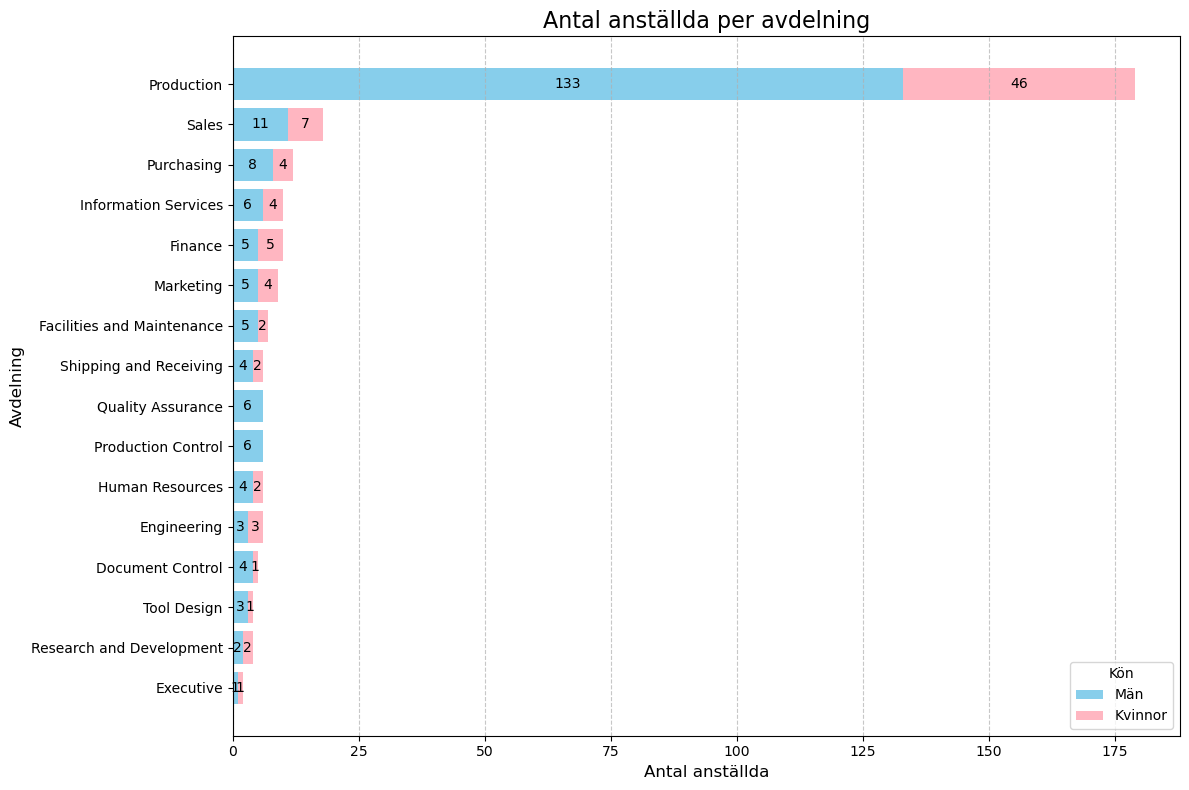

In [168]:
# Antalet anställda uppdelat per avdelning. Totalt 16 avdelningar. Produktion är störst med 179 av 290 anställda. 
# Alla avdelningar har fler män än kvinnor alt. lika många män som kvinnor. 

query = """
SELECT 
    ED.Department, 
    E.Gender, 
    COUNT(*) AS EmployeeCount
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
GROUP BY ED.Department, E.Gender
ORDER BY ED.Department, E.Gender;
"""
df = pd.read_sql(query, engine)

pivot_df = df.pivot(index="Department", columns="Gender", values="EmployeeCount").fillna(0)
pivot_df["Total"] = pivot_df.sum(axis=1)

pivot_df = pivot_df.sort_values(by="Total", ascending=True)

departments = pivot_df.index
male_counts = pivot_df["M"] if "M" in pivot_df.columns else np.zeros(len(departments))
female_counts = pivot_df["F"] if "F" in pivot_df.columns else np.zeros(len(departments))

x = np.arange(len(departments)) 

plt.figure(figsize=(12, 8))

plt.barh(x, male_counts, color="skyblue", label="Män")
plt.barh(x, female_counts, left=male_counts, color="lightpink", label="Kvinnor")

for i, (m_count, f_count) in enumerate(zip(male_counts, female_counts)):
    if m_count > 0:
        plt.text(m_count / 2, i, str(int(m_count)), va="center", ha="center", color="black", fontsize=10)
    if f_count > 0:
        plt.text(m_count + f_count / 2, i, str(int(f_count)), va="center", ha="center", color="black", fontsize=10)

plt.yticks(x, departments)
plt.xlabel("Antal anställda", fontsize=12)
plt.ylabel("Avdelning", fontsize=12)
plt.title("Antal anställda per avdelning", fontsize=16)
plt.legend(title="Kön")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()


##### Analys AdventureWorks-databasen

VILKA OMRÅDEN FÖRDJUPAR JAG MIG INOM OCH KANSKE NÅGON LITEN KOMMENTAR 


Anställning och anställningstid 

Av datan att bedömma inledde företaget sin verksamhet 2006 och det var också då de första anställdes. 
Den stora ökningen i anställningar kom 2008 för att nå sin topp under 2009 och sedan trappa av. 
Av allt att döma har företaget haft en tillväxtresa pga av uppstart och inga andra, tex säsongsrelaterade orsaker har kunnat identifieras. 
Avslutade anställningar är generellt mycket lågt till antalet och den genomsnittliga anställningstiden är hög, vilket tyder på att företaget generellt haft en mycket låg personalomsättning. 

Om man ska tolka diagrammet över anställda verkar det som att stödfunktioner så som ekonomi och ledning anställdes sent. 

Säsongsmässigt anställs flest på vintern, men ingen tydlig orsak till varför det är så har kunnat identifieras. 

Företaget har satsat på att anställa och bygga upp företaget först, för att sedan starta igång försäljningen. 

Företaget verkar ha växt först för sedan fortsääta stabilt. 

Anställningstiden är längst på de avdelningar som började anställa först? 


Om avdelningar har överlappande konfidensintervall kan vi inte säga med säkerhet att skillnaden är statistisk signifikant 
Vi kan itne säga särskilt mycket om de avdelningarna. Sales verkar ha en något högre rullians än övriga avdelningar 
så brukar det väl vara på företrag? 

Vad beror skillnaden på? Production började helt enkelt anställas tidigare. 
Det är inte ett företag med särskilt stor rullians av folk. 

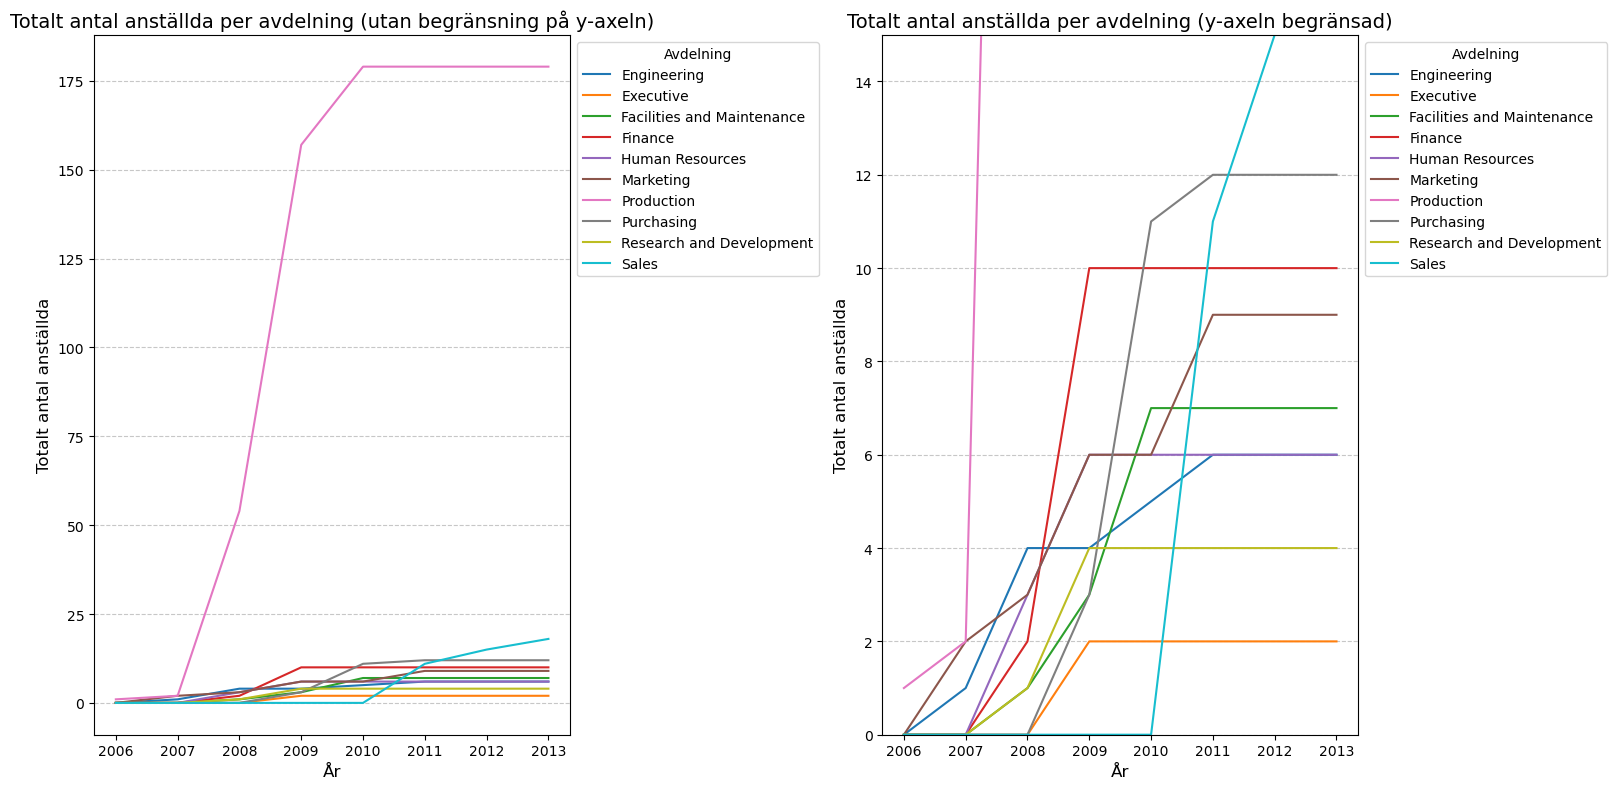

In [233]:
# Ackumulerat antal anställda per avdelning. 
# Flera avdelningar har exkluderats i grafen för att det ska vara lättare att se mönster. 
# I den högra grafen har y-axeln kapats, även detta för att enklare urskilja mönster. 

new_hires_query = """
SELECT 
    YEAR(E.HireDate) AS Year,
    ED.Department,
    COUNT(E.BusinessEntityID) AS NewHires
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
GROUP BY 
    YEAR(E.HireDate),
    ED.Department
ORDER BY 
    Year, 
    ED.Department;
"""
new_hires_data = pd.read_sql(new_hires_query, engine)

exclude_departments = [
    "Document Control", "Information Services", "Tool Design", 
    "Shipping and Receiving", "Quality Assurance", "Production Control"
]
filtered_hires_data = new_hires_data[~new_hires_data["Department"].isin(exclude_departments)]

pivot_new_hires = filtered_hires_data.pivot(index="Year", columns="Department", values="NewHires").fillna(0)
cumulative_employees = pivot_new_hires.cumsum()

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

# Graf 1
for department in cumulative_employees.columns:
    axes[0].plot(cumulative_employees.index, cumulative_employees[department], label=department)
axes[0].set_title("Totalt antal anställda per avdelning (utan begränsning på y-axeln)", fontsize=14)
axes[0].set_xlabel("År", fontsize=12)
axes[0].set_ylabel("Totalt antal anställda", fontsize=12)
axes[0].legend(title="Avdelning", loc="upper left", bbox_to_anchor=(1, 1))
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Graf 2
for department in cumulative_employees.columns:
    axes[1].plot(cumulative_employees.index, cumulative_employees[department], label=department)
axes[1].set_title("Totalt antal anställda per avdelning (y-axeln begränsad)", fontsize=14)
axes[1].set_xlabel("År", fontsize=12)
axes[1].set_ylabel("Totalt antal anställda", fontsize=12)
axes[1].set_ylim(0, 15)  # Begränsning på y-axeln
axes[1].legend(title="Avdelning", loc="upper left", bbox_to_anchor=(1, 1))
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

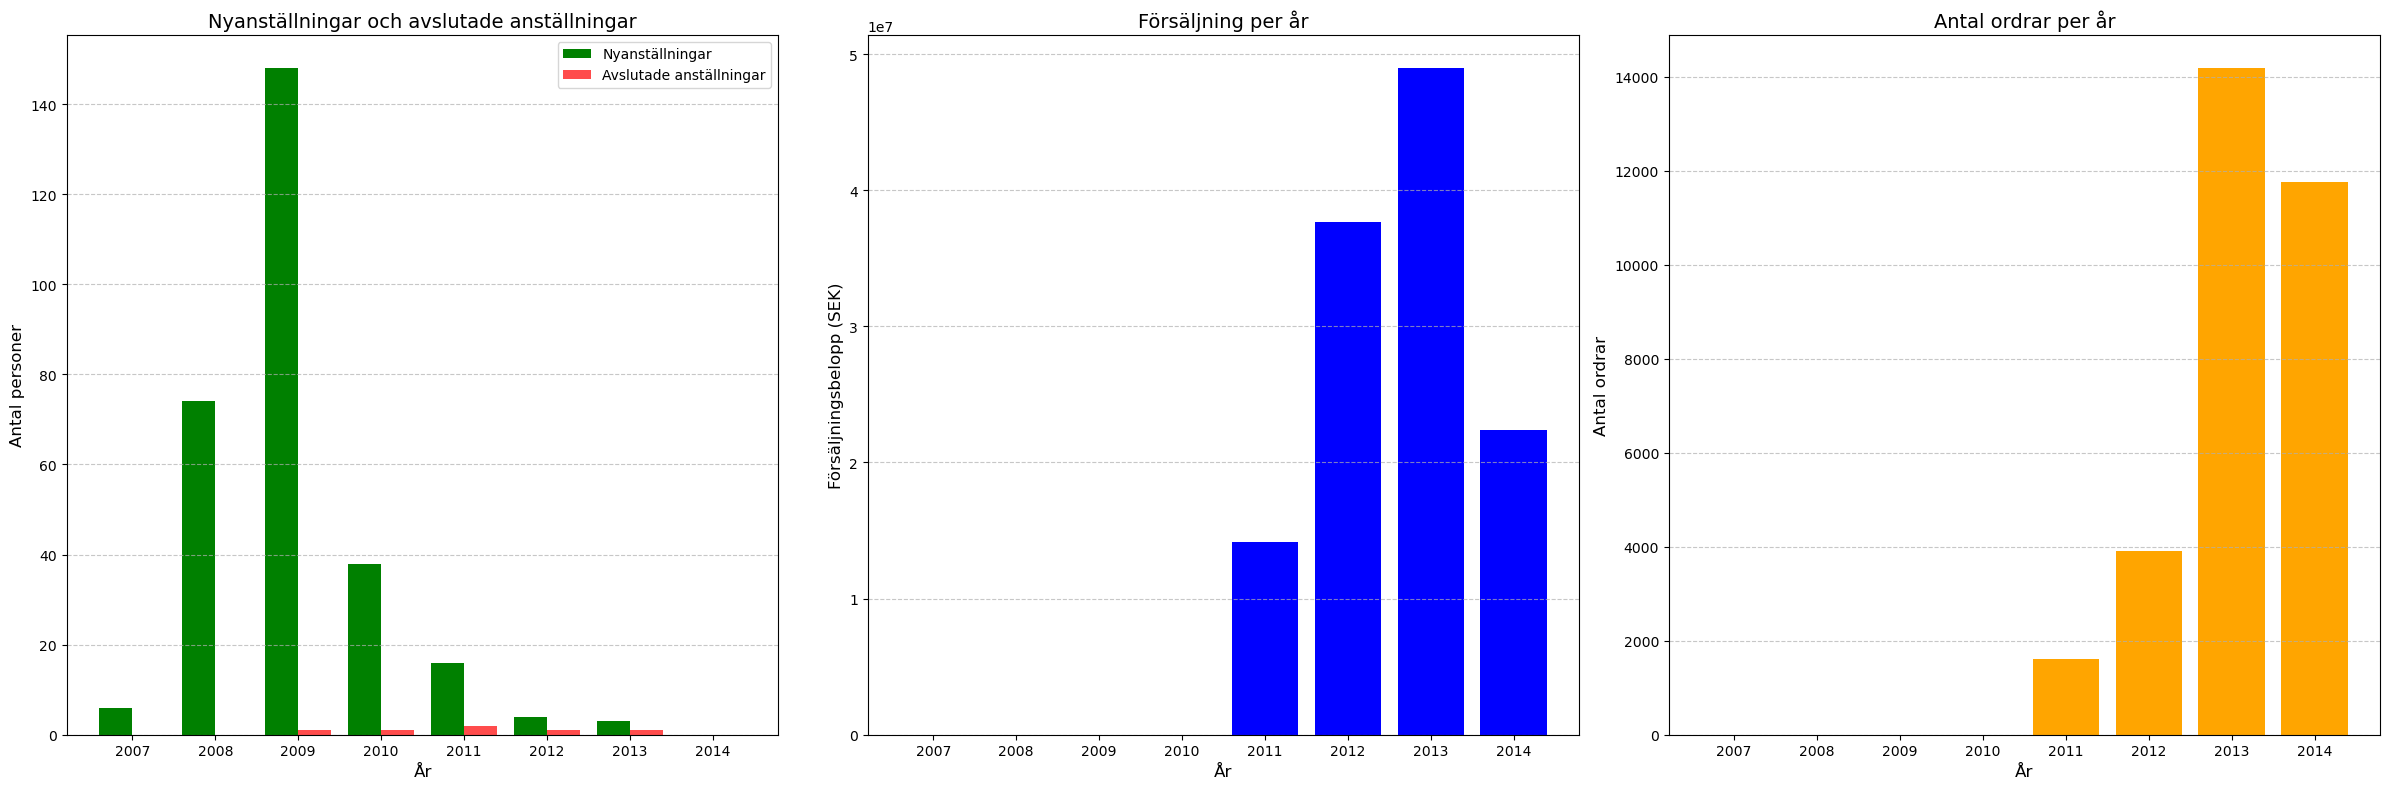

In [234]:
# Nyanställningar, avslutade anställningar, försäljning samt orderantal per år. 

hire_query = """
SELECT 
    FORMAT(HireDate, 'yyyy-MM') AS Month,
    COUNT(*) AS EmployeeCount
FROM HumanResources.Employee
GROUP BY FORMAT(HireDate, 'yyyy-MM')
ORDER BY Month;
"""
end_query = """
SELECT 
    FORMAT(EndDate, 'yyyy-MM') AS Month,
    COUNT(*) AS EmployeeCount
FROM HumanResources.EmployeeDepartmentHistory
WHERE EndDate IS NOT NULL
GROUP BY FORMAT(EndDate, 'yyyy-MM')
ORDER BY Month;
"""
sales_query = """
SELECT 
    FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
    SUM(TotalDue) AS SalesAmount
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY FORMAT(OrderDate, 'yyyy-MM');
"""
orders_query = """
SELECT 
    FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY FORMAT(OrderDate, 'yyyy-MM');
"""

hire_data = pd.read_sql(hire_query, engine)
end_data = pd.read_sql(end_query, engine)
sales_data = pd.read_sql(sales_query, engine)
orders_data = pd.read_sql(orders_query, engine)
hire_data["Month"] = pd.to_datetime(hire_data["Month"])
end_data["Month"] = pd.to_datetime(end_data["Month"])
sales_data['YearMonth'] = pd.to_datetime(sales_data['YearMonth'])
orders_data['YearMonth'] = pd.to_datetime(orders_data['YearMonth'])

merged_data = pd.merge(hire_data, end_data, on="Month", how="outer", suffixes=("_Hired", "_Ended")).fillna(0)
merged_data["EmployeeCount_Hired"] = pd.to_numeric(merged_data["EmployeeCount_Hired"])
merged_data["EmployeeCount_Ended"] = pd.to_numeric(merged_data["EmployeeCount_Ended"])
merged_data["Year"] = merged_data["Month"].dt.year
sales_data["Year"] = sales_data["YearMonth"].dt.year
orders_data["Year"] = orders_data["YearMonth"].dt.year

sales_yearly = sales_data.groupby("Year", as_index=False)["SalesAmount"].sum()
orders_yearly = orders_data.groupby("Year", as_index=False)["OrderCount"].sum()

years = pd.DataFrame({"Year": range(2007, 2015)})

merged_data_yearly = merged_data.groupby("Year", as_index=False)[["EmployeeCount_Hired", "EmployeeCount_Ended"]].sum()
sales_yearly = years.merge(sales_yearly, on="Year", how="left").fillna(0)
orders_yearly = years.merge(orders_yearly, on="Year", how="left").fillna(0)
merged_data_yearly = years.merge(merged_data_yearly, on="Year", how="left").fillna(0)

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Graf 1
width = 0.4
axes[0].bar(merged_data_yearly["Year"] - width/2, merged_data_yearly["EmployeeCount_Hired"], width=width, color="green", label="Nyanställningar")
axes[0].bar(merged_data_yearly["Year"] + width/2, merged_data_yearly["EmployeeCount_Ended"], width=width, color="red", label="Avslutade anställningar", alpha=0.7)
axes[0].set_title("Nyanställningar och avslutade anställningar", fontsize=14)
axes[0].set_xlabel("År", fontsize=12)
axes[0].set_ylabel("Antal personer", fontsize=12)
axes[0].set_xticks(years["Year"])
axes[0].legend()
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Graf 2 
axes[1].bar(sales_yearly["Year"], sales_yearly["SalesAmount"], color="blue", label="Försäljning")
axes[1].set_title("Försäljning per år", fontsize=14)
axes[1].set_xlabel("År", fontsize=12)
axes[1].set_ylabel("Försäljningsbelopp (SEK)", fontsize=12)
axes[1].set_xticks(years["Year"])
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Graf 3
axes[2].bar(orders_yearly["Year"], orders_yearly["OrderCount"], color="orange", label="Antal ordrar")
axes[2].set_title("Antal ordrar per år", fontsize=14)
axes[2].set_xlabel("År", fontsize=12)
axes[2].set_ylabel("Antal ordrar", fontsize=12)
axes[2].set_xticks(years["Year"])
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

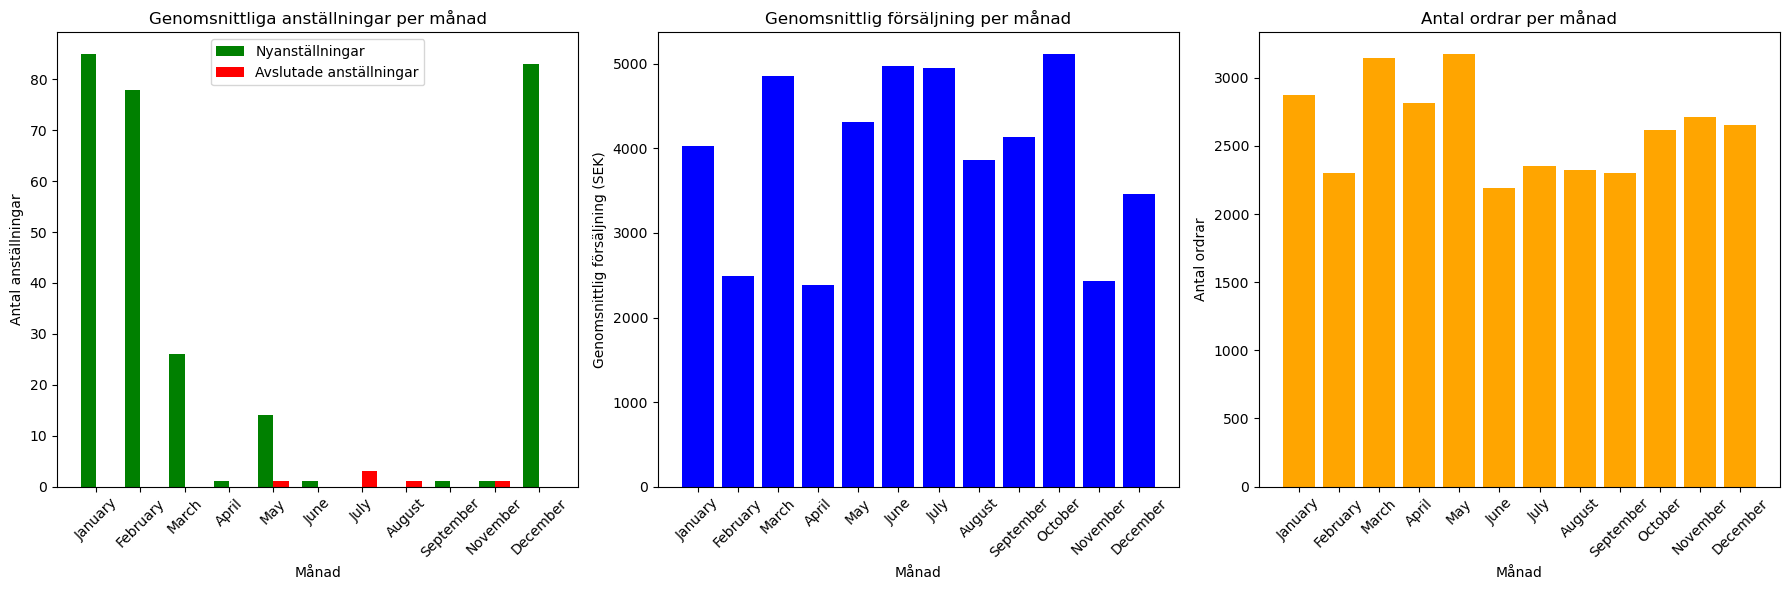

In [ ]:
# Nyanställningar, avslutade anställningar, försäljning samt orderantal månadsvis över ett år. 

hire_query = """
SELECT 
    DATENAME(MONTH, HireDate) AS Month,
    COUNT(*) AS EmployeeCount
FROM HumanResources.Employee
GROUP BY DATENAME(MONTH, HireDate), MONTH(HireDate)
ORDER BY MONTH(HireDate);
"""
hire_data = pd.read_sql(hire_query, engine)

end_query = """
SELECT 
    DATENAME(MONTH, EndDate) AS Month,
    COUNT(*) AS EmployeeCount
FROM HumanResources.EmployeeDepartmentHistory
WHERE EndDate IS NOT NULL
GROUP BY DATENAME(MONTH, EndDate), MONTH(EndDate)
ORDER BY MONTH(EndDate);
"""
end_data = pd.read_sql(end_query, engine)

sales_query = """
SELECT 
    DATENAME(MONTH, OrderDate) AS Month,
    AVG(TotalDue) AS SalesAmount
FROM Sales.SalesOrderHeader
GROUP BY DATENAME(MONTH, OrderDate), MONTH(OrderDate)
ORDER BY MONTH(OrderDate);
"""
sales_data = pd.read_sql(sales_query, engine)

order_query = """
SELECT 
    DATENAME(MONTH, OrderDate) AS Month,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY DATENAME(MONTH, OrderDate), MONTH(OrderDate)
ORDER BY MONTH(OrderDate);
"""
order_data = pd.read_sql(order_query, engine)

months_order = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]
hire_data["Month"] = pd.Categorical(hire_data["Month"], categories=months_order, ordered=True)
end_data["Month"] = pd.Categorical(end_data["Month"], categories=months_order, ordered=True)
sales_data["Month"] = pd.Categorical(sales_data["Month"], categories=months_order, ordered=True)
order_data["Month"] = pd.Categorical(order_data["Month"], categories=months_order, ordered=True)

hire_data["EmployeeCount"] = hire_data["EmployeeCount"].fillna(0)
end_data["EmployeeCount"] = end_data["EmployeeCount"].fillna(0)

hire_end_data = pd.merge(hire_data, end_data, on="Month", how="outer", suffixes=("_Hired", "_Ended"))

hire_end_data["EmployeeCount_Hired"] = hire_end_data["EmployeeCount_Hired"].fillna(0)
hire_end_data["EmployeeCount_Ended"] = hire_end_data["EmployeeCount_Ended"].fillna(0)

hire_end_data["EmployeeCount_Hired"] = pd.to_numeric(hire_end_data["EmployeeCount_Hired"])
hire_end_data["EmployeeCount_Ended"] = pd.to_numeric(hire_end_data["EmployeeCount_Ended"])
 

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Graf 1
x = range(len(hire_end_data["Month"]))
bar_width = 0.35

axes[0].bar(x, hire_end_data["EmployeeCount_Hired"], width=bar_width, color="green", label="Nyanställningar")
axes[0].bar([i + bar_width for i in x], hire_end_data["EmployeeCount_Ended"], width=bar_width, color="red", label="Avslutade anställningar")
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(hire_end_data["Month"])
axes[0].set_title("Genomsnittliga anställningar per månad")
axes[0].set_xlabel("Månad")
axes[0].set_ylabel("Antal anställningar")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend()

# Graf 2: Genomsnittlig försäljning
axes[1].bar(sales_data["Month"], sales_data["SalesAmount"], color="blue")
axes[1].set_title("Genomsnittlig försäljning per månad")
axes[1].set_xlabel("Månad")
axes[1].set_ylabel("Genomsnittlig försäljning (SEK)")
axes[1].tick_params(axis="x", rotation=45)

# Graf 3: Antal ordrar per månad
axes[2].bar(order_data["Month"], order_data["OrderCount"], color="orange")
axes[2].set_title("Antal ordrar per månad")
axes[2].set_xlabel("Månad")
axes[2].set_ylabel("Antal ordrar")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

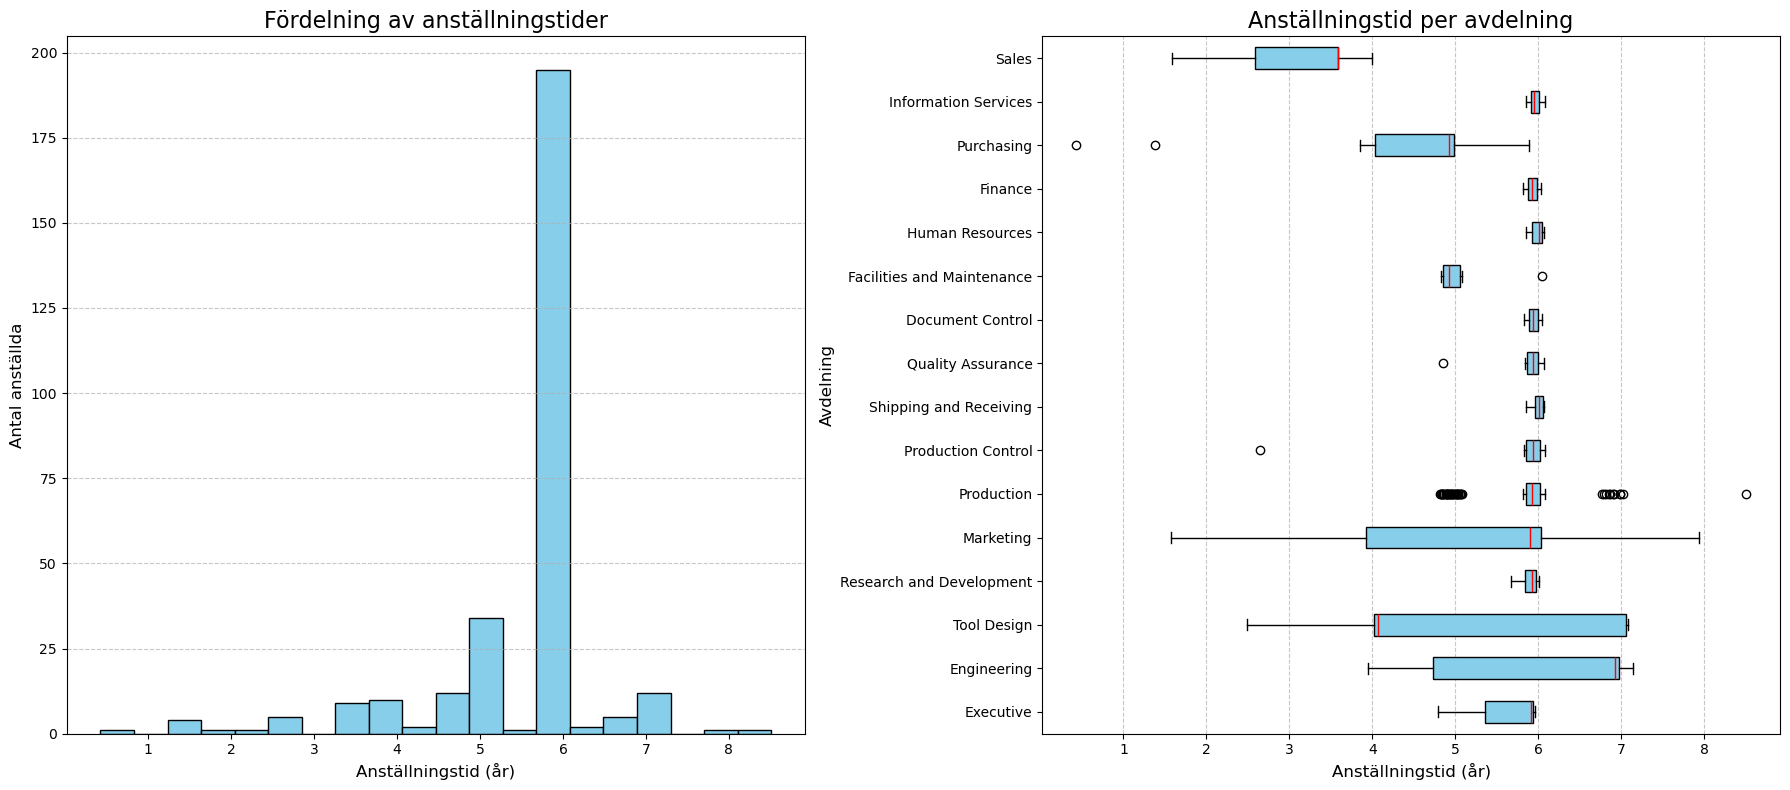

In [240]:
# Anställningstider

tenure_query = """
SELECT 
    ED.Department,
    DATEDIFF(DAY, E.HireDate, 
        CASE 
            WHEN H.EndDate IS NOT NULL THEN H.EndDate
            ELSE '2014-12-31'
        END
    ) / 365.0 AS YearsEmployed
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
LEFT JOIN HumanResources.EmployeeDepartmentHistory AS H
    ON E.BusinessEntityID = H.BusinessEntityID;
"""

# Hämta data
tenure_data = pd.read_sql(tenure_query, engine)

# Skapa figuren och subplotarna
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Histogram för anställningstider
axes[0].hist(tenure_data["YearsEmployed"], bins=20, color="skyblue", edgecolor="black")
axes[0].set_title("Fördelning av anställningstider", fontsize=16)
axes[0].set_xlabel("Anställningstid (år)", fontsize=12)
axes[0].set_ylabel("Antal anställda", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Låddiagram för anställningstider per avdelning
departments = tenure_data["Department"].unique()
data = [tenure_data[tenure_data["Department"] == dept]["YearsEmployed"].dropna() for dept in departments]

axes[1].boxplot(data, vert=False, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', color='black'),
                medianprops=dict(color='red'))
axes[1].set_yticks(range(1, len(departments) + 1))
axes[1].set_yticklabels(departments, fontsize=10)
axes[1].set_title("Anställningstid per avdelning", fontsize=16)
axes[1].set_xlabel("Anställningstid (år)", fontsize=12)
axes[1].set_ylabel("Avdelning", fontsize=12)
axes[1].grid(axis="x", linestyle="--", alpha=0.7)

# Anpassa layout
plt.tight_layout()
plt.show()

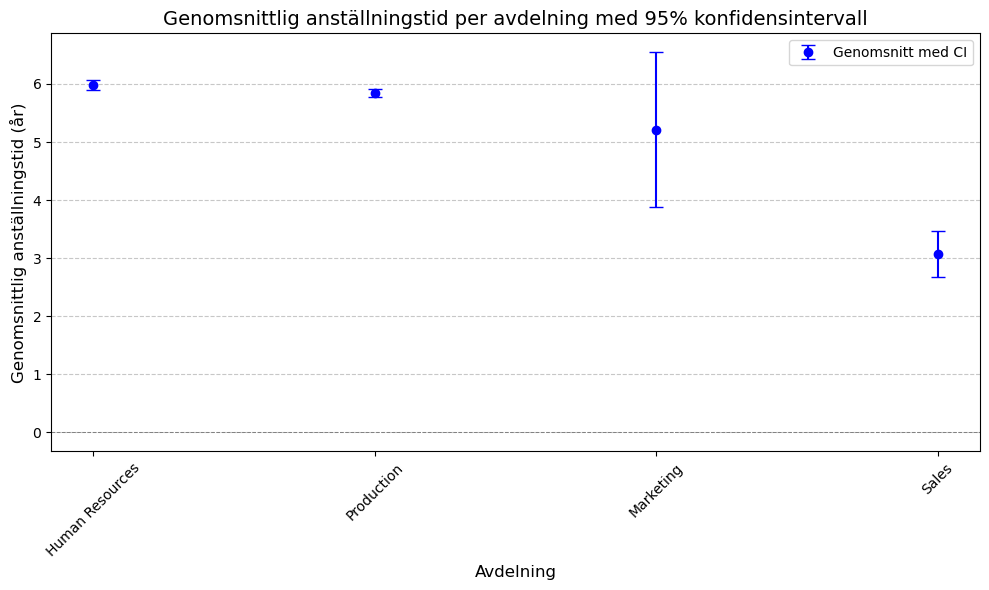

In [243]:
# Jämförelse av den genomsnittliga anställningstiden för fyra avdelningar för att se om det finns en statistiskt säkerställd skillnad mellan avdelningar. 

query = """
SELECT 
    ED.Department,
    DATEDIFF(DAY, E.HireDate, 
        CASE 
            WHEN H.EndDate IS NOT NULL THEN H.EndDate
            ELSE '2014-12-31'
        END
    ) / 365.0 AS YearsEmployed
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
LEFT JOIN HumanResources.EmployeeDepartmentHistory AS H
    ON E.BusinessEntityID = H.BusinessEntityID
WHERE ED.Department IN ('Sales', 'Human Resources', 'Production', 'Marketing')  -- Utvalda avdelningar
"""
# Läs in data till DataFrame
tenure_data = pd.read_sql(query, engine)

# Funktion för att beräkna konfidensintervall
def calculate_confidence_interval(data, confidence=0.95):
    mean = data.mean()
    std = data.std()
    n = len(data)
    if n > 1:
        se = std / (n ** 0.5)  # Standardfel
        t_value = t.ppf((1 + confidence) / 2, df=n - 1)  # t-kritiskt värde
        ci_lower = mean - t_value * se
        ci_upper = mean + t_value * se
        return mean, ci_lower, ci_upper
    else:
        return mean, None, None

# Beräkna CI för varje avdelning
results = []
departments = tenure_data["Department"].unique()

for department in departments:
    dept_data = tenure_data[tenure_data["Department"] == department]["YearsEmployed"]
    mean, ci_lower, ci_upper = calculate_confidence_interval(dept_data)
    results.append({"Department": department, "Mean": mean, "CI_Lower": ci_lower, "CI_Upper": ci_upper})

# Konvertera till DataFrame för visualisering
ci_df = pd.DataFrame(results).sort_values(by="Mean", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(ci_df["Department"], ci_df["Mean"], 
             yerr=[ci_df["Mean"] - ci_df["CI_Lower"], ci_df["CI_Upper"] - ci_df["Mean"]],
             fmt='o', capsize=5, color='blue', label="Genomsnitt med CI")
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)

# Anpassa diagram
plt.title("Genomsnittlig anställningstid per avdelning med 95% konfidensintervall", fontsize=14)
plt.xlabel("Avdelning", fontsize=12)
plt.ylabel("Genomsnittlig anställningstid (år)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

In [247]:
# Jämförelse av den genomsnittliga anställningstiden för avdelningarna Production och Sales för att se om det finns en statistiskt säkerställd skillnad mellan avdelningar.

query = """
SELECT 
    ED.Department,
    DATEDIFF(DAY, E.HireDate, ISNULL(H.EndDate, '2014-12-31')) / 365.0 AS YearsEmployed
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
LEFT JOIN HumanResources.EmployeeDepartmentHistory AS H
    ON E.BusinessEntityID = H.BusinessEntityID
    AND H.EndDate IS NOT NULL
WHERE ED.Department IN ('Sales', 'Production')  -- Begränsad till två avdelningar för t-test
"""

# Läs in data till DataFrame
tenure_data = pd.read_sql(query, engine)

# Sammanfattande statistik
summary_stats = tenure_data.groupby("Department")["YearsEmployed"].agg(
    Mean="mean", StdDev="std", Count="count"
).reset_index()

# Utför t-test mellan "Production" och "Sales"
production_data = tenure_data[tenure_data["Department"] == "Production"]["YearsEmployed"]
sales_data = tenure_data[tenure_data["Department"] == "Sales"]["YearsEmployed"]
t_stat, p_value = ttest_ind(production_data, sales_data, equal_var=False)

# Förbered t-test resultat
t_test_results = [
    {
        "T-statistik": round(t_stat, 4),
        "P-värde": round(p_value, 4),
        "Signifikans": "Ja" if p_value < 0.05 else "Nej"
    }
]

# Förbered t-test resultat som en lista av listor
t_test_results = [
    [round(t_stat, 4), round(p_value, 4), "Ja" if p_value < 0.05 else "Nej"]
]

# Presentera t-test tabell
t_test_table = tabulate(
    t_test_results,
    headers=["T-statistik", "P-värde", "Signifikans"],
    tablefmt="pretty"
)

# Visa resultaten
print("Sammanfattande statistik:")
print(summary_table)
print("\nT-test resultat:")
print(t_test_table)

# Slutsats baserad på p-värdet
if p_value < 0.01:
    print("Det finns en statistiskt signifikant skillnad mellan anställningstiden för Production och Sales.")
else:
    print("Det finns ingen statistiskt signifikant skillnad mellan anställningstiden för Production och Sales.")

Sammanfattande statistik:
+---+------------+--------------------+------------------------+---------------------+
|   | Avdelning  |  Medelvärde (år)   | Standardavvikelse (år) | Antal observationer |
+---+------------+--------------------+------------------------+---------------------+
| 0 | Production | 5.843728005586592  |   0.5074549308828187   |         179         |
| 1 |   Sales    | 3.0715371111111107 |   0.8111722133193412   |         18          |
+---+------------+--------------------+------------------------+---------------------+

T-test resultat:
+-------------+---------+-------------+
| T-statistik | P-värde | Signifikans |
+-------------+---------+-------------+
|   14.2221   |   0.0   |     Ja      |
+-------------+---------+-------------+
Det finns en statistiskt signifikant skillnad mellan anställningstiden för Production och Sales.


Lön beroende på kön och rollnivå 

Kvinnor verkar ha en något högra genomsnittlig lön än män, det är dock inte statistiskt säkerställt # LÄGG TILL DETTA SÅ MAN KAN SE DEN UTVÄRDERINGEN 
Analys av data visar att alla, oavsett kön, har samma lön för samma roll. 
Varför har då kvinnor möjligtvis en högre lön? 
De har en större andel roller med högre befattning. 

Göra en linjör regressionsmodell för att se vilka faktorer som påverkar lön (roll, kön, avdelning, anställningstid etc) hade utökat analysen. 

Det vore intressant att göra en linjär regressionsmodell för att se vad som påverkar lön och se om kön eller roll har en påverkan. Även tex anställningstid kan inkluderas i detta. eller avdelning också. Så detta blir endast en mycket enkel analys byggd på intuition. 

Lägg till intervall på sker så som lönen och om det är statistiskt säkerställt att kvinnor tjänar mer 

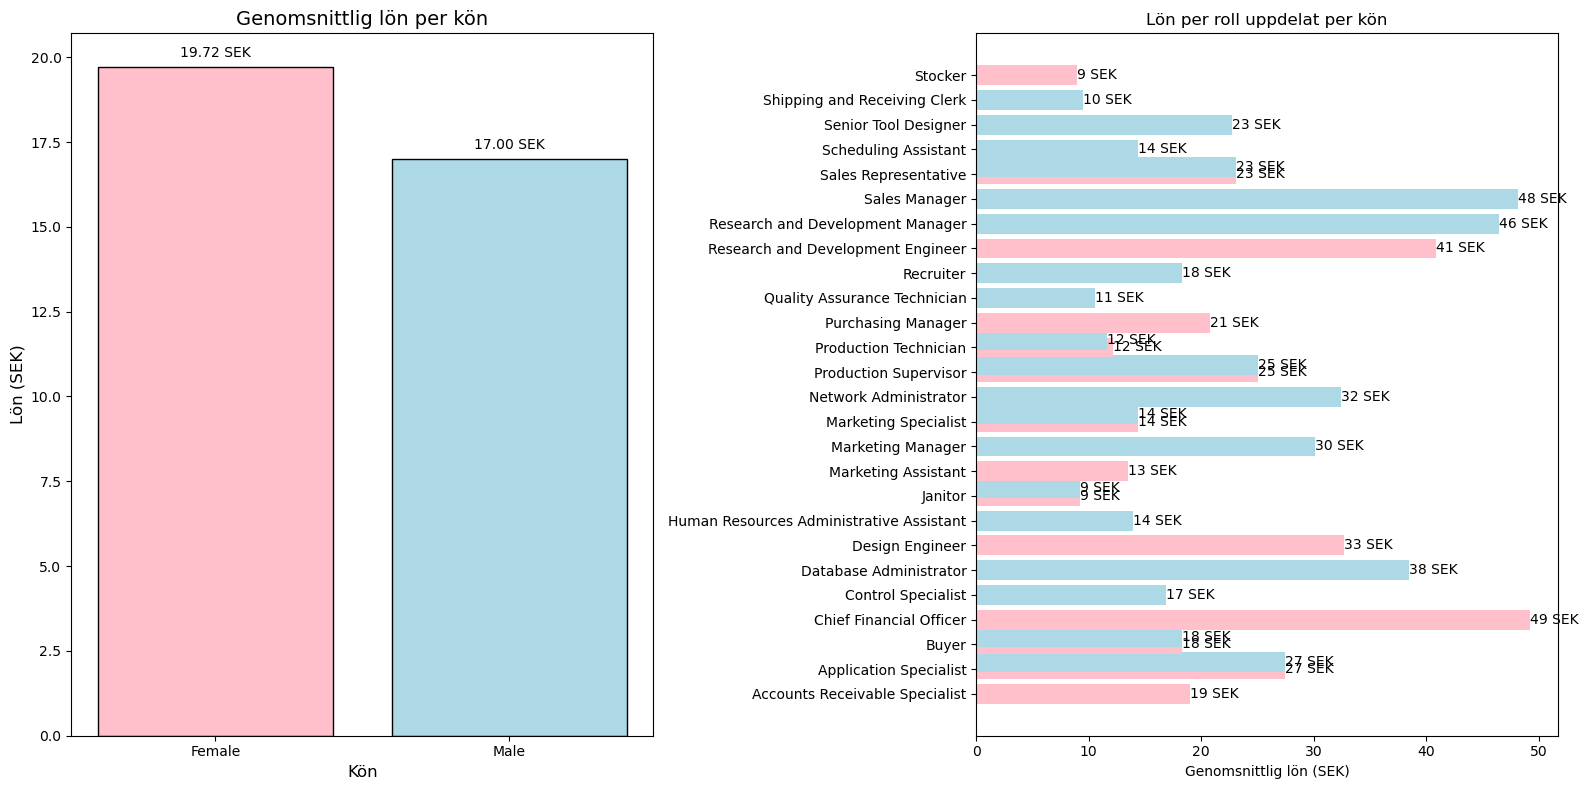

In [ ]:



# Diagram 1: Genomsnittlig lön per kön
gender_salary_query = """
SELECT 
    E.Gender,
    AVG(CAST(PH.Rate AS DECIMAL(10, 2))) AS AverageSalary
FROM 
    HumanResources.Employee AS E
INNER JOIN 
    HumanResources.EmployeePayHistory AS PH
    ON E.BusinessEntityID = PH.BusinessEntityID
GROUP BY 
    E.Gender;
"""
gender_salary_df = pd.read_sql(gender_salary_query, engine)
gender_salary_df['Gender'] = gender_salary_df['Gender'].replace({'M': 'Male', 'F': 'Female'})

# Diagram 2: Lön per roll och kön
role_salary_query = """ 
SELECT 
    CASE 
        WHEN E.JobTitle LIKE 'Production Supervisor%' THEN 'Production Supervisor'
        WHEN E.JobTitle LIKE 'Production Technician%' THEN 'Production Technician'
        WHEN E.JobTitle LIKE '%Sales Manager%' THEN 'Sales Manager'
        ELSE E.JobTitle
    END AS JobTitle,
    E.Gender,
    AVG(CAST(PH.Rate AS DECIMAL(10, 2))) AS AverageSalary
FROM 
    HumanResources.Employee AS E
INNER JOIN 
    HumanResources.EmployeePayHistory AS PH
    ON E.BusinessEntityID = PH.BusinessEntityID
GROUP BY 
    CASE 
        WHEN E.JobTitle LIKE 'Production Supervisor%' THEN 'Production Supervisor'
        WHEN E.JobTitle LIKE 'Production Technician%' THEN 'Production Technician'
        WHEN E.JobTitle LIKE '%Sales Manager%' THEN 'Sales Manager'
        ELSE E.JobTitle
    END,
    E.Gender
HAVING 
    COUNT(E.BusinessEntityID) > 1
ORDER BY 
    JobTitle, E.Gender;
"""
role_salary_df = pd.read_sql(role_salary_query, engine)
role_salary_df['Gender'] = role_salary_df['Gender'].replace({'M': 'Male', 'F': 'Female'})
role_salary_df['Color'] = role_salary_df['Gender'].map({'Male': 'lightblue', 'Female': 'pink'})

# Skapa två diagram bredvid varandra
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Diagram 1: Stapeldiagram för genomsnittlig lön per kön
axes[0].bar(
    gender_salary_df['Gender'], 
    gender_salary_df['AverageSalary'], 
    color=['pink', 'lightblue'], 
    edgecolor='black'
)
for i, val in enumerate(gender_salary_df['AverageSalary']):
    axes[0].text(i, val + 0.3, f"{val:.2f} SEK", ha='center', fontsize=10)
axes[0].set_title("Genomsnittlig lön per kön", fontsize=14)
axes[0].set_ylabel("Lön (SEK)", fontsize=12)
axes[0].set_xlabel("Kön", fontsize=12)

# Diagram 2: Liggande stapeldiagram för lön per roll och kön
for idx, (job, group) in enumerate(role_salary_df.groupby('JobTitle')):
    y_positions = [idx + (i * 0.3) for i in range(len(group))]
    axes[1].barh(
        y=y_positions,
        width=group['AverageSalary'],
        color=group['Color']
    )
    for i, row in group.iterrows():
        axes[1].text(row['AverageSalary'], y_positions[group.index.get_loc(i)], 
                     f"{row['AverageSalary']:.0f} SEK", va="center")
axes[1].set_yticks(range(len(role_salary_df['JobTitle'].unique())))
axes[1].set_yticklabels(role_salary_df['JobTitle'].unique(), fontsize=10)
axes[1].set_xlabel("Genomsnittlig lön (SEK)")
axes[1].set_title("Lön per roll uppdelat per kön")

# Justera layout och visa
plt.tight_layout()
plt.show()

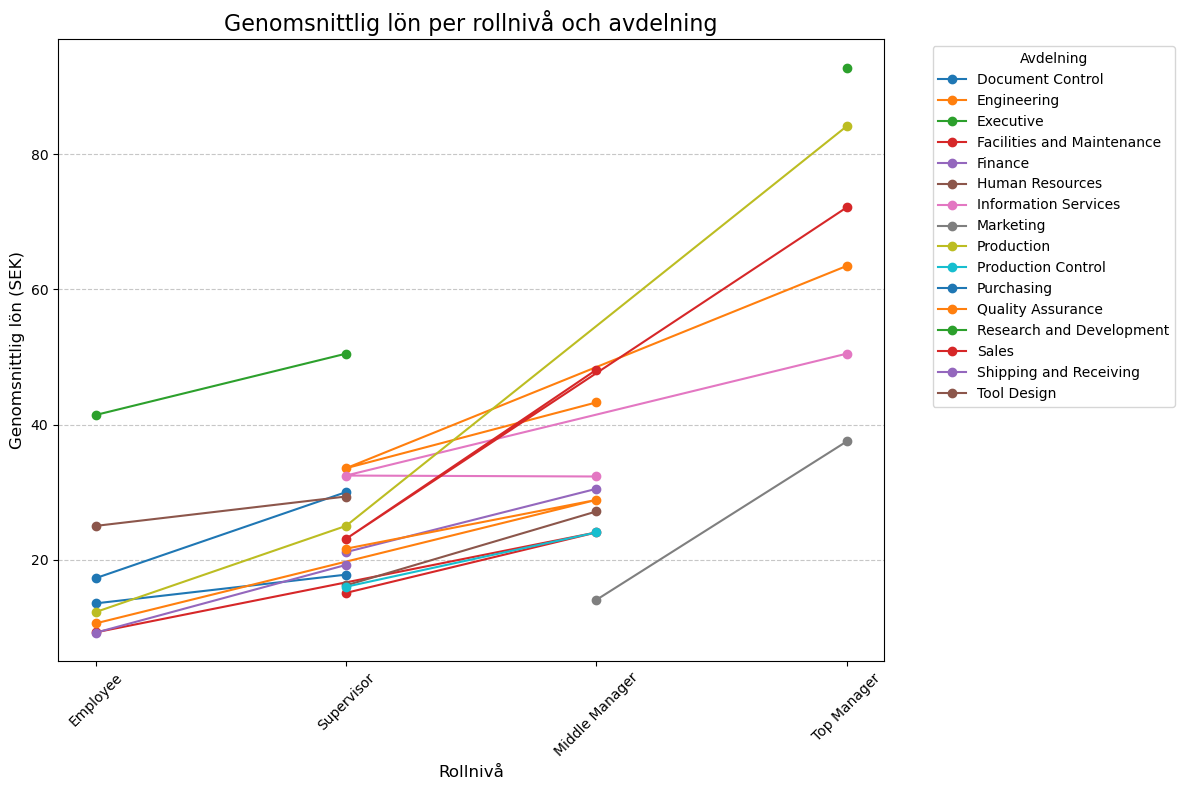

In [256]:
# Hämta data med den uppdaterade SQL-frågan
query = """
SELECT 
    ED.Department,
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager'
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Supervisor'
        ELSE 'Employee'
    END AS RoleLevel,
    AVG(CAST(PH.Rate AS DECIMAL(10, 2))) AS AverageSalary
FROM 
    HumanResources.Employee AS E
INNER JOIN 
    (SELECT 
         BusinessEntityID, 
         Rate, 
         ROW_NUMBER() OVER (PARTITION BY BusinessEntityID ORDER BY RateChangeDate DESC) AS RowNum
     FROM HumanResources.EmployeePayHistory) AS PH
    ON E.BusinessEntityID = PH.BusinessEntityID AND PH.RowNum = 1
INNER JOIN 
    HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
GROUP BY 
    ED.Department,
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager'
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Supervisor'
        ELSE 'Employee'
    END
ORDER BY 
    ED.Department,
    RoleLevel;
"""

# Läs in resultatet till en DataFrame
df = pd.read_sql(query, engine)

# Visualisering som linjediagram
plt.figure(figsize=(12, 8))

# Hämta unika avdelningar
departments = df['Department'].unique()

# Iterera genom avdelningarna och plotta data
for department in departments:
    dept_data = df[df['Department'] == department]
    plt.plot(dept_data['RoleLevel'], dept_data['AverageSalary'], marker='o', label=department)

# Anpassa diagrammet
plt.title("Genomsnittlig lön per rollnivå och avdelning", fontsize=16)
plt.xlabel("Rollnivå", fontsize=12)
plt.ylabel("Genomsnittlig lön (SEK)", fontsize=12)
plt.legend(title="Avdelning", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Visa diagrammet
plt.show()

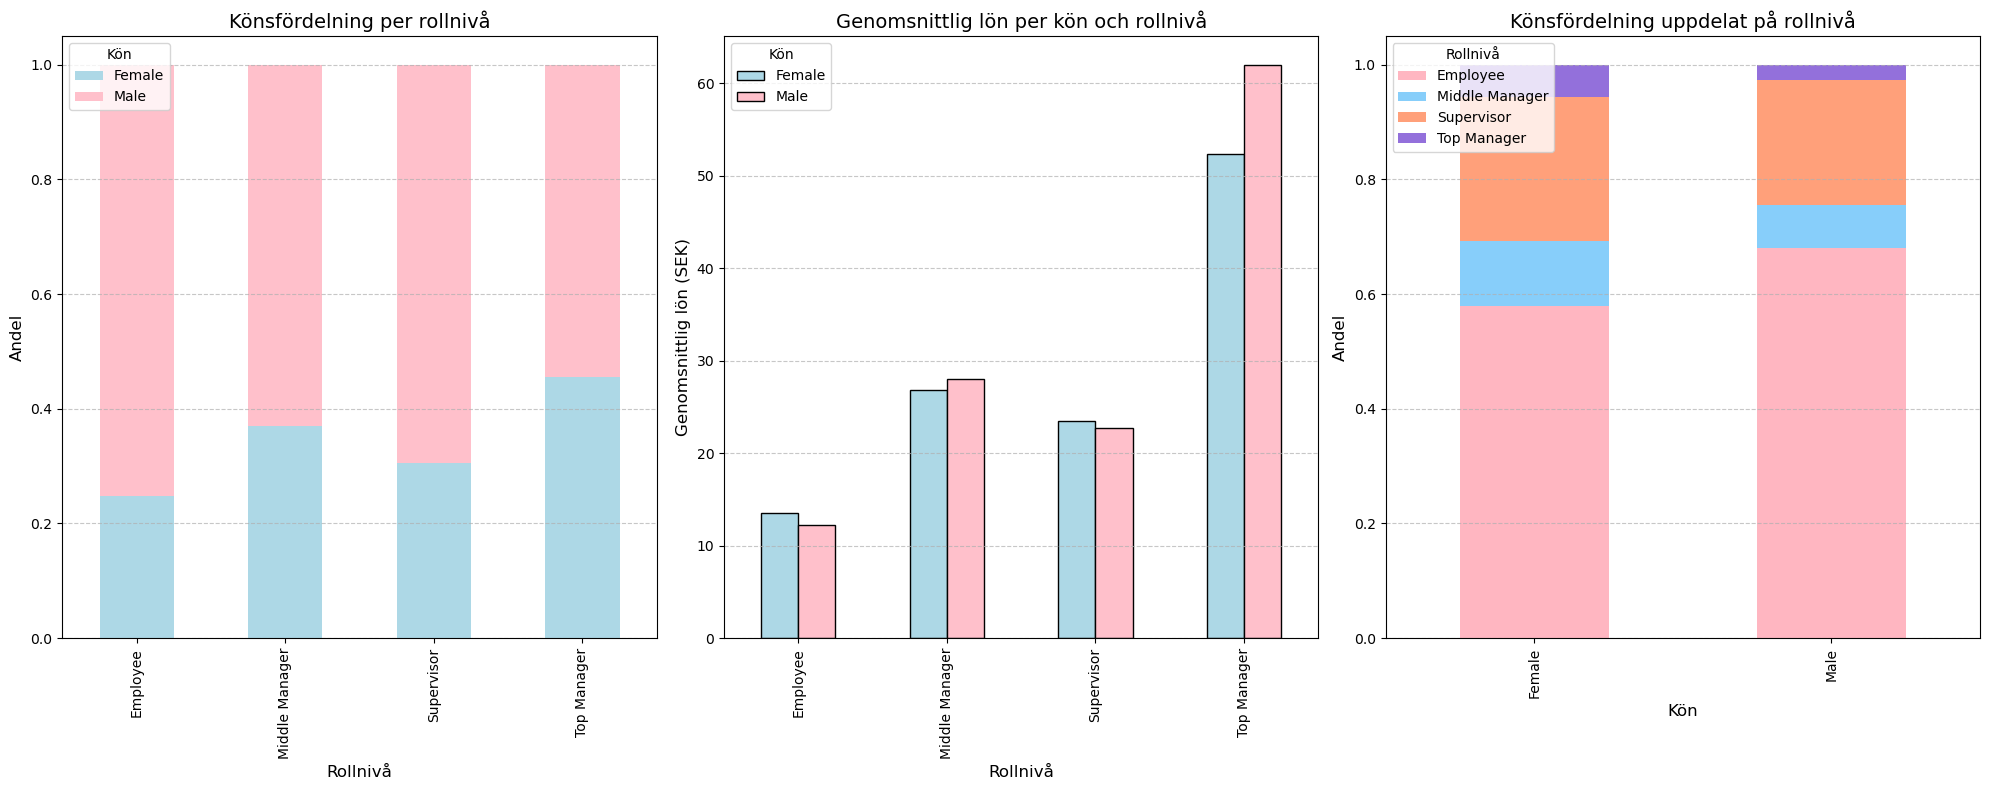

In [274]:
# SQL-fråga för att hämta data
query = """
SELECT 
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager'
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Supervisor'
        ELSE 'Employee'
    END AS RoleLevel,
    E.Gender,
    AVG(CAST(PH.Rate AS DECIMAL(10, 2))) AS AverageSalary,
    COUNT(E.BusinessEntityID) AS EmployeeCount
FROM 
    HumanResources.Employee AS E
INNER JOIN 
    HumanResources.EmployeePayHistory AS PH
    ON E.BusinessEntityID = PH.BusinessEntityID
GROUP BY 
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager'
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Supervisor'
        ELSE 'Employee'
    END,
    E.Gender
ORDER BY RoleLevel, E.Gender;
"""
df = pd.read_sql(query, engine)

# Omvandla kön och rollnivå till mer läsbara etiketter
df['Gender'] = df['Gender'].replace({'M': 'Male', 'F': 'Female'})

# Förbered figuren
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# 1. Fördelning av kön per rollnivå
gender_distribution = df.pivot_table(index='RoleLevel', columns='Gender', values='EmployeeCount', aggfunc='sum').fillna(0)
gender_distribution_norm = gender_distribution.div(gender_distribution.sum(axis=1), axis=0)

gender_distribution_norm.plot(kind='bar', stacked=True, ax=axes[0], color=['lightblue', 'pink'])
axes[0].set_title("Könsfördelning per rollnivå", fontsize=14)
axes[0].set_xlabel("Rollnivå", fontsize=12)
axes[0].set_ylabel("Andel", fontsize=12)
axes[0].legend(title="Kön", loc='upper left')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Genomsnittlig lön per kön och rollnivå
salary_pivot = df.pivot(index='RoleLevel', columns='Gender', values='AverageSalary')
salary_pivot.plot(kind='bar', ax=axes[1], color=['lightblue', 'pink'], edgecolor='black')
axes[1].set_title("Genomsnittlig lön per kön och rollnivå", fontsize=14)
axes[1].set_xlabel("Rollnivå", fontsize=12)
axes[1].set_ylabel("Genomsnittlig lön (SEK)", fontsize=12)
axes[1].legend(title="Kön", loc='upper left')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# 3. Könsandel per rollnivå (indelad stapeldiagram)
pivot = df.pivot_table(index='Gender', columns='RoleLevel', values='EmployeeCount', aggfunc='sum').fillna(0)
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

pivot_norm.plot(kind='bar', stacked=True, ax=axes[2], color=['#FFB6C1', '#87CEFA', '#FFA07A', '#9370DB'])  # Färger för rollnivåer
axes[2].set_title("Könsfördelning uppdelat på rollnivå", fontsize=14)
axes[2].set_xlabel("Kön", fontsize=12)
axes[2].set_ylabel("Andel", fontsize=12)
axes[2].legend(title="Rollnivå", loc='upper left')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Anpassa layout
plt.tight_layout()
plt.show()

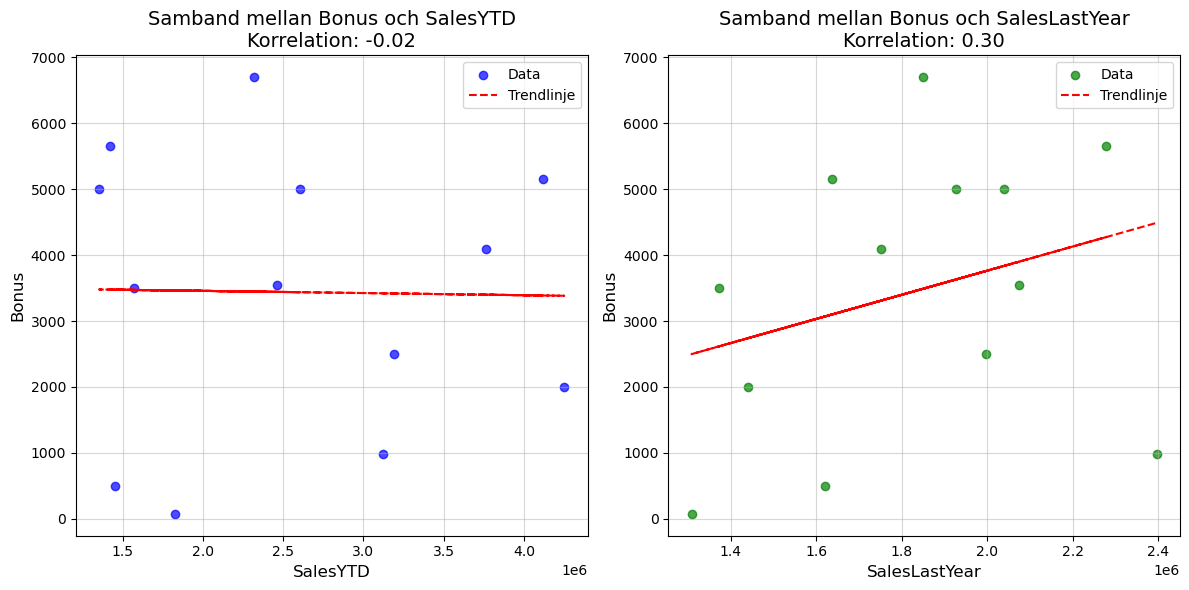

In [273]:
# Inte helt tydligt. 

query = """
SELECT 
    BusinessEntityID AS SalesPersonID,
    Bonus,
    SalesYTD,
    SalesLastYear
FROM 
    Sales.SalesPerson
WHERE 
    Bonus > 0 AND SalesYTD > 0 AND SalesLastYear > 0;
"""
df = pd.read_sql(query, engine)

# Beräkna korrelationer
correlation_ytd = df['Bonus'].corr(df['SalesYTD'])
correlation_last_year = df['Bonus'].corr(df['SalesLastYear'])

# Skapa figuren
plt.figure(figsize=(12, 6))

# Scatter plot och trendlinje för SalesYTD
plt.subplot(1, 2, 1)
x = df['SalesYTD']
y = df['Bonus']

# Beräkna linjär trendlinje
coeffs_ytd = np.polyfit(x, y, 1)  # Linjär regression
trendline_ytd = np.poly1d(coeffs_ytd)

# Plot
plt.scatter(x, y, color="blue", alpha=0.7, label="Data")
plt.plot(x, trendline_ytd(x), color="red", linestyle="--", label="Trendlinje")
plt.title(f"Samband mellan Bonus och SalesYTD\nKorrelation: {correlation_ytd:.2f}", fontsize=14)
plt.xlabel("SalesYTD", fontsize=12)
plt.ylabel("Bonus", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

# Scatter plot och trendlinje för SalesLastYear
plt.subplot(1, 2, 2)
x = df['SalesLastYear']
y = df['Bonus']

# Beräkna linjär trendlinje
coeffs_last_year = np.polyfit(x, y, 1)  # Linjär regression
trendline_last_year = np.poly1d(coeffs_last_year)

# Plot
plt.scatter(x, y, color="green", alpha=0.7, label="Data")
plt.plot(x, trendline_last_year(x), color="red", linestyle="--", label="Trendlinje")
plt.title(f"Samband mellan Bonus och SalesLastYear\nKorrelation: {correlation_last_year:.2f}", fontsize=14)
plt.xlabel("SalesLastYear", fontsize=12)
plt.ylabel("Bonus", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

# Layout
plt.tight_layout()
plt.show()

Försäljning av cyklar 
Vilka cyklar säljer mest

## Fördelning av försäljning av cyklar per land/region: Vilka marknader presterar bäst? Kan man få in större och mindre bollar i ett diagram? 
## Vanligaste produkterna: Vilka produkter säljs mest?

C:\Users\teres\AppData\Local\Temp\ipykernel_51416\3390842703.py:73: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



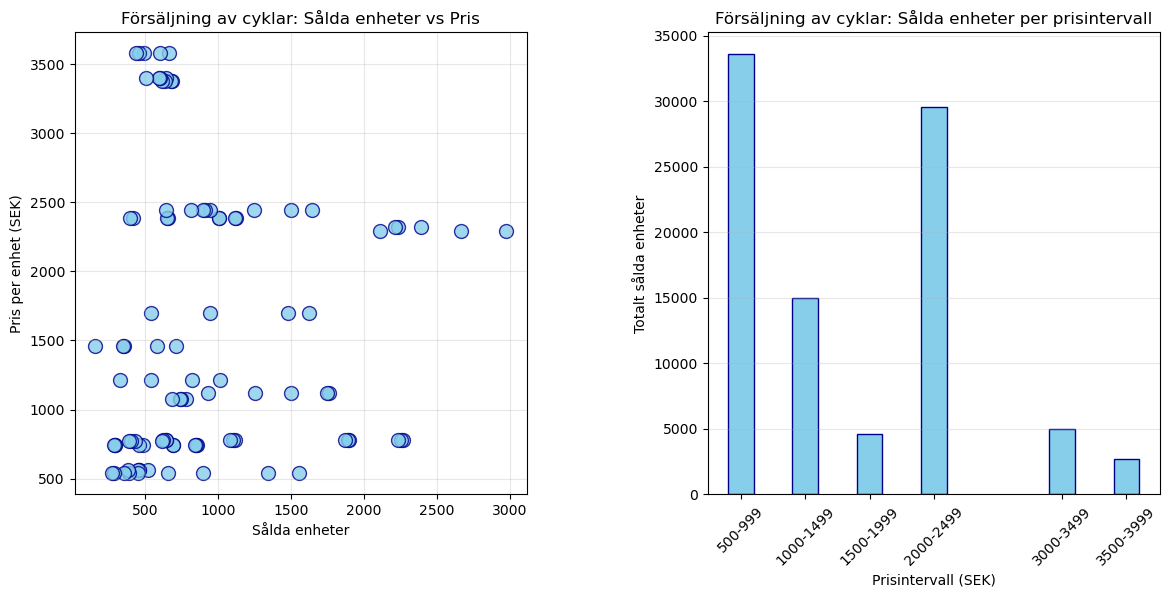

In [275]:
# SQL-fråga för att hämta data
query = """
SELECT 
    P.Name AS ProductName,
    SUM(SOD.OrderQty) AS TotalQuantitySold,
    P.ListPrice AS UnitPrice
FROM 
    Sales.SalesOrderDetail AS SOD
INNER JOIN 
    Production.Product AS P
    ON SOD.ProductID = P.ProductID
INNER JOIN 
    Production.ProductSubcategory AS PSC
    ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
INNER JOIN 
    Production.ProductCategory AS PC
    ON PSC.ProductCategoryID = PC.ProductCategoryID
WHERE 
    PC.Name = 'Bikes'
GROUP BY 
    P.Name, P.ListPrice
ORDER BY 
    TotalQuantitySold DESC, UnitPrice DESC;
"""

# Hämta data
bike_sales_data = pd.read_sql(query, engine)

# Skapa en ny kolumn för prisintervall
price_interval = 500
bike_sales_data['PriceRange'] = (
    (bike_sales_data['UnitPrice'] // price_interval) * price_interval
).astype(int)

# Gruppera data efter prisintervall
grouped_data = bike_sales_data.groupby('PriceRange').agg(
    TotalQuantitySold=('TotalQuantitySold', 'sum')
).reset_index()

# Skapa figuren och subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.4})

# Diagram 1: Scatterplot
axes[0].scatter(
    bike_sales_data['TotalQuantitySold'],
    bike_sales_data['UnitPrice'],
    alpha=0.8,
    c='skyblue',
    edgecolors='darkblue',
    s=100
)
axes[0].set_xlabel('Sålda enheter')
axes[0].set_ylabel('Pris per enhet (SEK)')
axes[0].set_title('Försäljning av cyklar: Sålda enheter vs Pris')
axes[0].grid(alpha=0.3)

# Diagram 2: Stapeldiagram
axes[1].bar(
    grouped_data['PriceRange'],
    grouped_data['TotalQuantitySold'],
    width=200,
    color='skyblue',
    edgecolor='darkblue'
)
axes[1].set_xlabel('Prisintervall (SEK)')
axes[1].set_ylabel('Totalt sålda enheter')
axes[1].set_title('Försäljning av cyklar: Sålda enheter per prisintervall')
axes[1].set_xticks(grouped_data['PriceRange'])
axes[1].set_xticklabels([f"{r}-{r+price_interval-1}" for r in grouped_data['PriceRange']], rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Visa diagrammen
plt.tight_layout()
plt.show()

Jämför Andel dyra sålda priser per territorium med BNP för varje land 

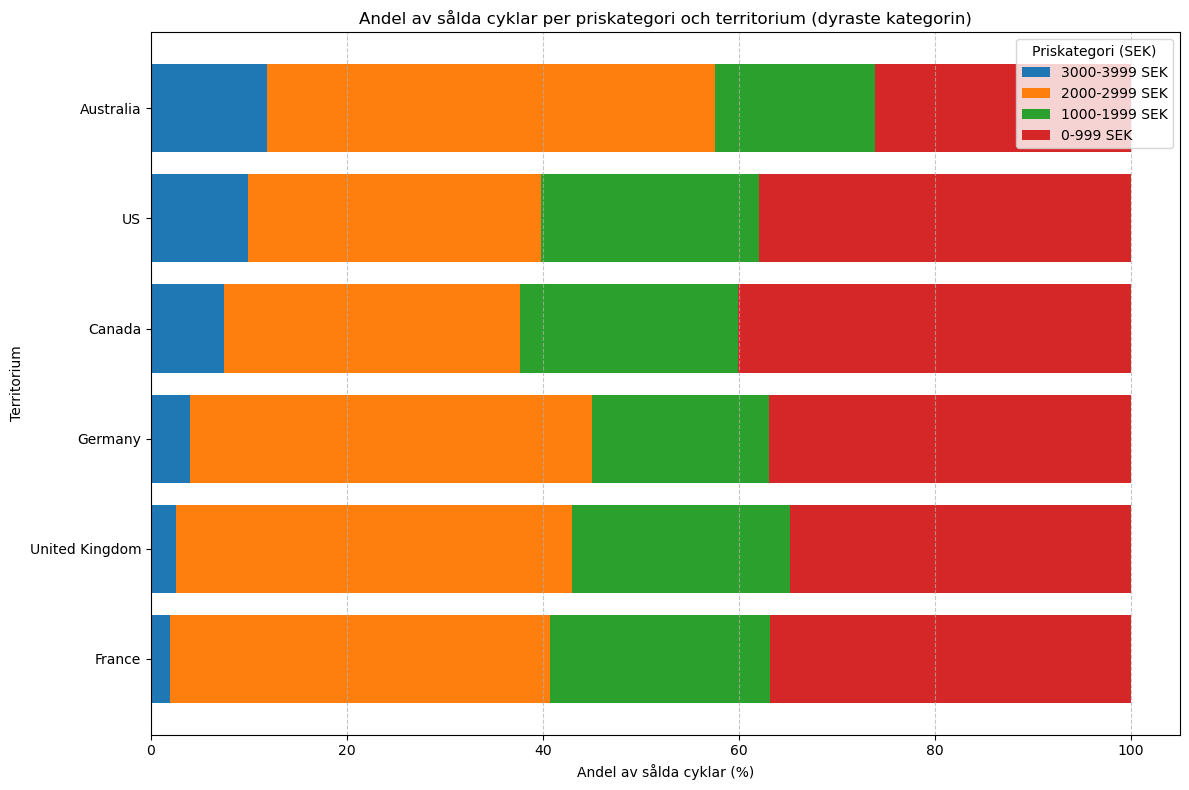

In [276]:
query = """
SELECT 
    T.Name AS TerritoryName,
    P.Name AS ProductName,
    SUM(SOD.OrderQty) AS TotalQuantitySold,
    P.ListPrice AS UnitPrice
FROM 
    Sales.SalesOrderDetail AS SOD
INNER JOIN 
    Production.Product AS P
    ON SOD.ProductID = P.ProductID
INNER JOIN 
    Production.ProductSubcategory AS PSC
    ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
INNER JOIN 
    Production.ProductCategory AS PC
    ON PSC.ProductCategoryID = PC.ProductCategoryID
INNER JOIN 
    Sales.SalesOrderHeader AS SOH
    ON SOD.SalesOrderID = SOH.SalesOrderID
INNER JOIN 
    Sales.SalesTerritory AS T
    ON SOH.TerritoryID = T.TerritoryID
WHERE 
    PC.Name = 'Bikes'
GROUP BY 
    T.Name, P.Name, P.ListPrice
ORDER BY 
    T.Name, TotalQuantitySold DESC, UnitPrice DESC;
"""
# Hämta data från databasen
bike_sales_data = pd.read_sql(query, engine)

# Sammanfoga alla territorier i USA till "US"
usa_territories = ['Northeast', 'Northwest', 'Southeast', 'Southwest', 'Central']
bike_sales_data['TerritoryName'] = bike_sales_data['TerritoryName'].replace(usa_territories, 'US')

# Uppdatera prisintervall till 1000 SEK
price_interval = 1000
bike_sales_data['PriceRange'] = (
    (bike_sales_data['UnitPrice'] // price_interval) * price_interval
).astype(int)

# Gruppera data efter territorium och prisintervall
grouped_data = bike_sales_data.groupby(['TerritoryName', 'PriceRange']).agg(
    TotalQuantitySold=('TotalQuantitySold', 'sum')
).reset_index()

# Beräkna total försäljning per territorium
total_per_territory = grouped_data.groupby('TerritoryName')['TotalQuantitySold'].transform('sum')

# Beräkna andel för varje priskategori inom varje territorium
grouped_data['Percentage'] = grouped_data['TotalQuantitySold'] / total_per_territory * 100

# Kontrollera att andelarna summerar till 100% per territorium
sum_per_territory = grouped_data.groupby('TerritoryName')['Percentage'].sum()
assert all(sum_per_territory.round(0) == 100), "Andelarna summerar inte korrekt till 100%."

# Diagram: Sortera baserat på dyraste priskategorin
highest_price_range = grouped_data['PriceRange'].max()
territory_order_expensive = (
    grouped_data[grouped_data['PriceRange'] == highest_price_range]
    .sort_values('Percentage', ascending=False)['TerritoryName']
    .unique()
)

# Vänd sorteringen för dyraste priskategorin
territory_order_expensive = territory_order_expensive[::-1]

# Sortera data
grouped_data['TerritoryName'] = pd.Categorical(
    grouped_data['TerritoryName'],
    categories=territory_order_expensive,
    ordered=True
)
grouped_expensive = grouped_data.sort_values(by=['TerritoryName', 'PriceRange'], ascending=[True, False])

# Skapa diagram för dyraste kategorin
plt.figure(figsize=(12, 8))
stacked_start = pd.Series(0, index=territory_order_expensive, dtype=float)
for price_range in sorted(grouped_expensive['PriceRange'].unique(), reverse=True):
    price_range_data = grouped_expensive[grouped_expensive['PriceRange'] == price_range]
    plt.barh(
        price_range_data['TerritoryName'],
        price_range_data['Percentage'],
        label=f"{price_range}-{price_range + price_interval - 1} SEK",
        left=stacked_start[price_range_data['TerritoryName']].values
    )
    stacked_start += price_range_data.set_index('TerritoryName')['Percentage']
plt.xlabel("Andel av sålda cyklar (%)")
plt.ylabel("Territorium")
plt.title("Andel av sålda cyklar per priskategori och territorium (dyraste kategorin)")
plt.legend(title="Priskategori (SEK)", loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### Självutvärdering 

